In [1]:
from adapter import T2IAdapter
from pipeline_xl_adapter import StableDiffusionXLAdapterPipeline
import torch
from controlnet_aux import SamDetector
from PIL import Image
import urllib
from torchvision import transforms

/home/sargezt/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-08-02 21:07:14,546] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-08-02 21:07:14.900357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 21:07:15.714013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-02 21:07:15.714078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-02 21:07:15.714084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
resolution = 1024
n_steps = 40
high_noise_frac = 0.8

In [3]:
dtype = torch.float16
device = "cuda"
adapter = T2IAdapter.from_pretrained("SargeZT/t2i-adapter-sdxl-segmentation").to(
    dtype=dtype, device=device
)
base = StableDiffusionXLAdapterPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    adapter=adapter,
).to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]


In [9]:
from diffusers import DiffusionPipeline
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]


StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.19.3",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "force_zeros_for_empty_prompt": false,
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [11]:
sam = SamDetector.from_pretrained("ybelkada/segment-anything", subfolder="checkpoints")

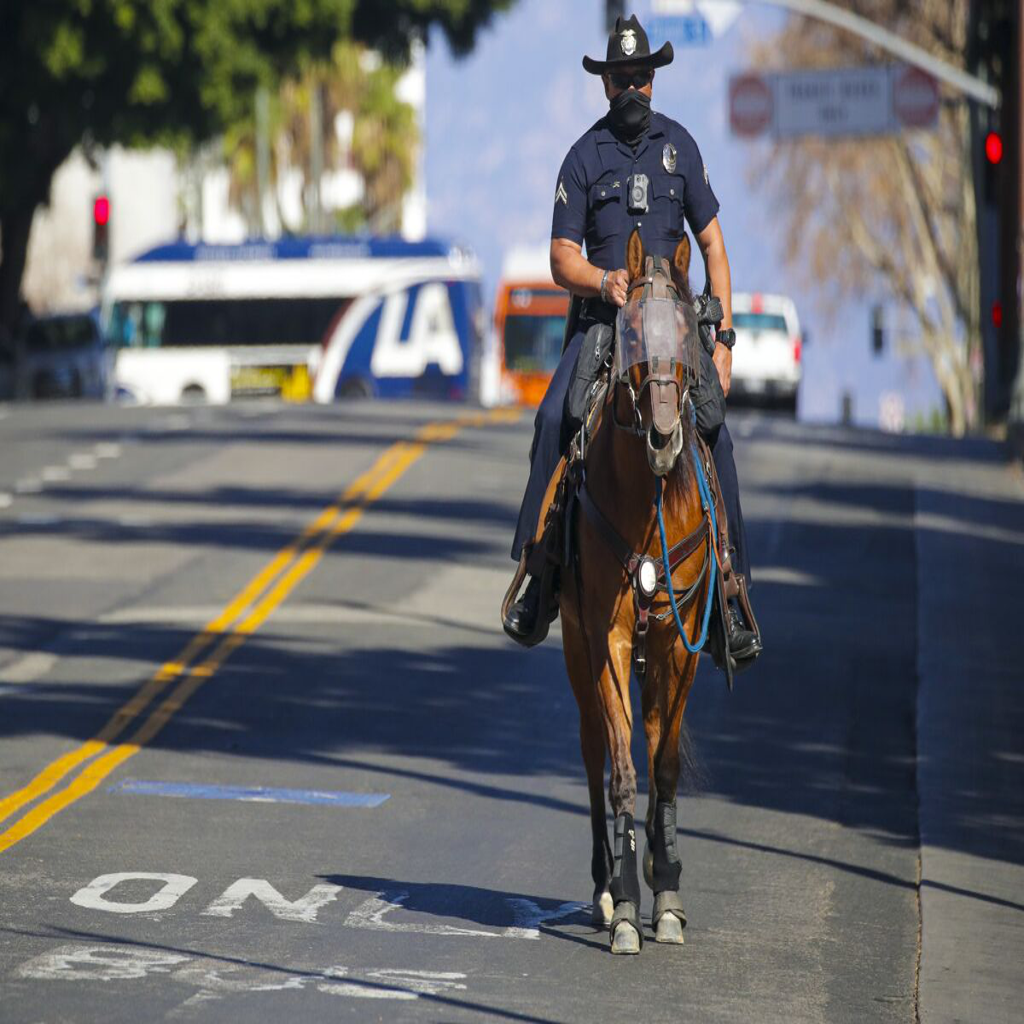

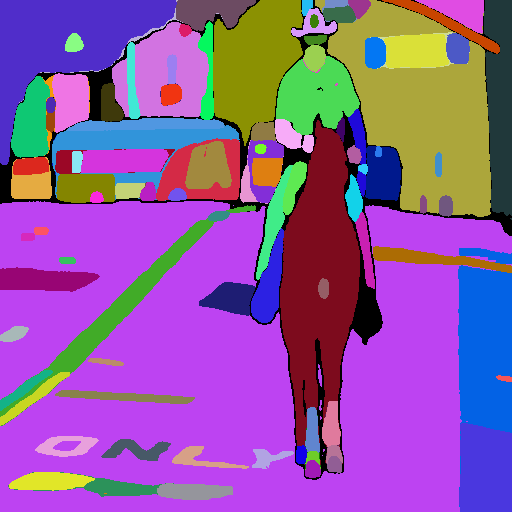

In [12]:
input_url = "https://ca-times.brightspotcdn.com/dims4/default/167bfeb/2147483647/strip/true/crop/2400x1600+0+0/resize/1200x800!/quality/80/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fb9%2F06%2F58ccf43e4162bd2115c662cc087e%2Fla-photos-1staff-692345-me-0120-heightened-alert-dtla12.IK.JPG"
with urllib.request.urlopen(input_url) as url:
    with open("input.jpg", "wb") as f:
        f.write(url.read())
input_image = Image.open("input.jpg")

new_size = (resolution, resolution)
input_image = input_image.resize(new_size)

display(input_image)

# Segment the image
preprocessed_image = sam(input_image)
display(preprocessed_image)

In [13]:
transform = transforms.Compose(
    [
        transforms.Resize(
            resolution,
            interpolation=transforms.InterpolationMode.BILINEAR,
        ),
        transforms.CenterCrop(resolution),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(dtype=dtype),
    ]
)
preprocessed_image_t = transform(preprocessed_image).unsqueeze(0)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  6.63it/s]


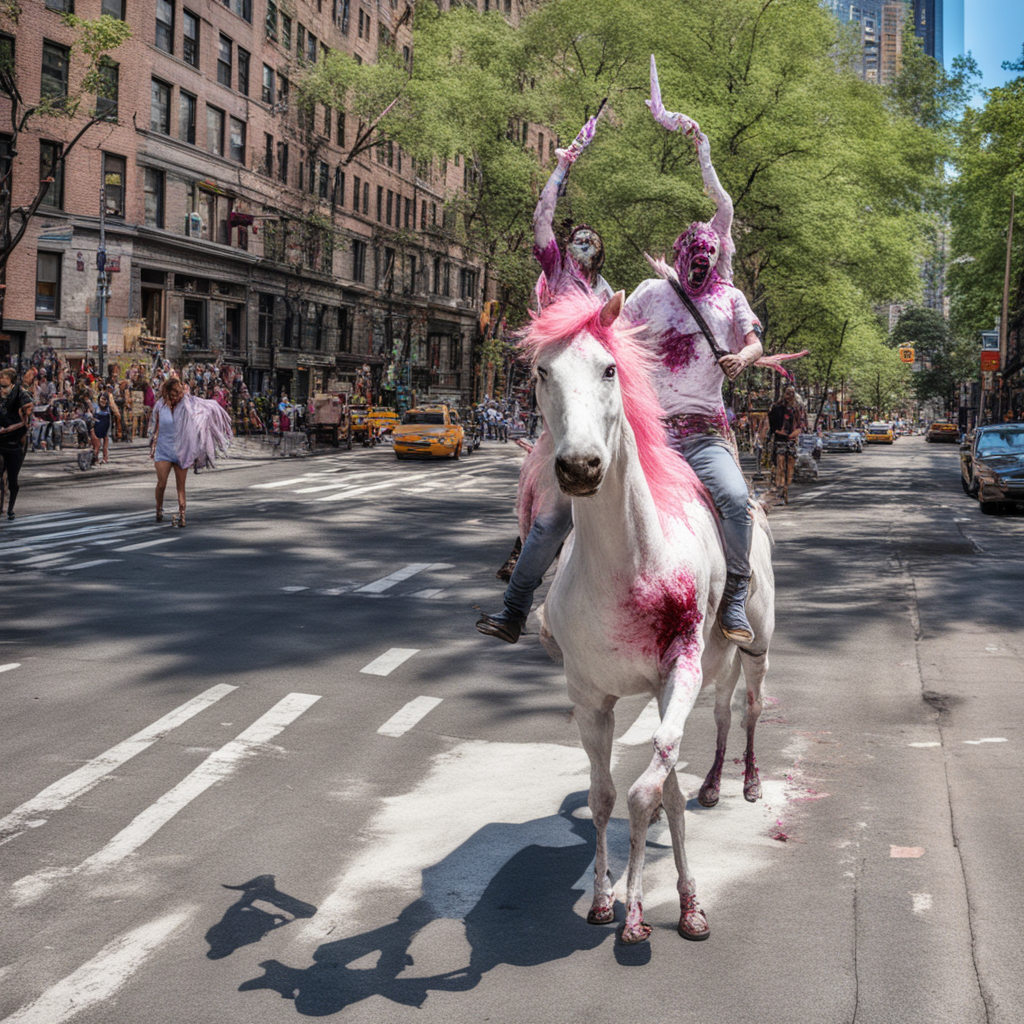

In [17]:
prompt = "An zombie riding a unicorn in New York City"

base_output = base(
    prompt=prompt,
    height=resolution,
    width=resolution,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
    image=preprocessed_image_t,
    guidance_scale=9.0,
).images

image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=base_output,
).images[0]
display(image)